In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# all pairs btw 2319 genes
cluster = pd.read_csv("../../result/emb/hdbscan_dagma.txt", sep="\t", header=None)

all_pairs = [pair[0]+"_"+pair[1] for pair in itertools.permutations(cluster[0].values, 2)]
all_pairs = pd.DataFrame(all_pairs)

### within emb clusters or not

In [3]:
cluster = pd.read_csv("../../result/emb/hdbscan_dagma.txt", sep="\t", header=None)

within_cluster_pair = []
for ii in cluster[1].unique():
    if ii != -1:
        sub = cluster[cluster[1] == ii]
        for pair in itertools.permutations(sub[0].values, 2):
            within_cluster_pair.append(pair[0]+"_"+pair[1])

all_pairs[1] = all_pairs[0].isin(within_cluster_pair)

### within Replogle clusters or not

In [4]:
cluster = pd.read_csv("../../data/perturb/clustered_mean_gene_expression_figs2-4.csv", low_memory=False).iloc[2:, :2]

cluster.columns = [0, 1]

within_cluster_pair = []
for ii in cluster[1].unique():
    if ii != -1:
        sub = cluster[cluster[1] == ii]
        for pair in itertools.permutations(sub[0].values, 2):
            within_cluster_pair.append(pair[0]+"_"+pair[1])

all_pairs[2] = all_pairs[0].isin(within_cluster_pair)

### within coexp clusters or not

In [5]:
cluster = pd.read_csv("../../result/emb/hdbscan_corr.txt", sep="\t", header=None)

within_cluster_pair = []
for ii in cluster[1].unique():
    if ii != -1:
        sub = cluster[cluster[1] == ii]
        for pair in itertools.permutations(sub[0].values, 2):
            within_cluster_pair.append(pair[0]+"_"+pair[1])

all_pairs[3] = all_pairs[0].isin(within_cluster_pair)

### adding STRING score

In [6]:
# convert to Ensembl protein ID
links = pd.read_csv("../../data/STRING/9606.protein.physical.links.v11.5.txt", sep=" ")
links['protein1'] = links['protein1'].str.split("9606.", expand=True)[1]
links['protein2'] = links['protein2'].str.split("9606.", expand=True)[1]

# convert Ensembl protein ID to Ensembl gene ID
eP2eG = pd.read_csv("../../data/Ensembl/EnsemblP2EnsemblG.txt", sep="\t", header=None).dropna().copy()
eP2eG = eP2eG.set_index(0)[1].to_dict()
links['protein1'] = links['protein1'].map(eP2eG)
links['protein2'] = links['protein2'].map(eP2eG)
links = links.dropna().copy()

data = sc.read_h5ad("../../data/perturb/K562_gwps_normalized_bulk_01.h5ad")
id2name = data.var['gene_name'].to_dict()
links['protein1'] = links['protein1'].map(id2name)
links['protein2'] = links['protein2'].map(id2name)
# keep only both ends existed in the full perturb-seq data
links = links.dropna().copy()

links['pair'] = links['protein1']+"_"+links["protein2"]

string_dict = links.set_index("pair")['combined_score'].to_dict()

all_pairs[4] = all_pairs[0].map(string_dict)

### adding co-exp

In [7]:
df = pd.read_csv("../../data/perturb/clustered_mean_gene_expression_figs2-4.csv", sep=",", index_col=0, low_memory=False)
df = df.iloc[2:, 1:].T

# compute correlation of expression
corr_df = df.corr()
corr = pd.DataFrame(corr_df.values.reshape(-1))
corr[1] = list(corr_df.index) * 2319
corr[2] = np.repeat(list(corr_df.index), 2319)

corr[3] = corr[1]+"_"+corr[2]

corr_dict = corr.set_index(3)[0].to_dict()

all_pairs[5] = all_pairs[0].map(corr_dict)

### compare STRING

In [8]:
all_pairs_dropna = all_pairs.dropna().copy()
v1 = all_pairs_dropna[all_pairs_dropna[1]][4].abs().values
v2 = all_pairs_dropna[all_pairs_dropna[2]][4].abs().values
v3 = all_pairs_dropna[all_pairs_dropna[3]][4].abs().values
result = pd.DataFrame(np.concatenate([v1, v3, v2]))
result[1] = ["Emb_LatentDAG"] * len(v1) + ["Emb_Combine"] * len(v3) + ["Replogle"] * len(v2) 

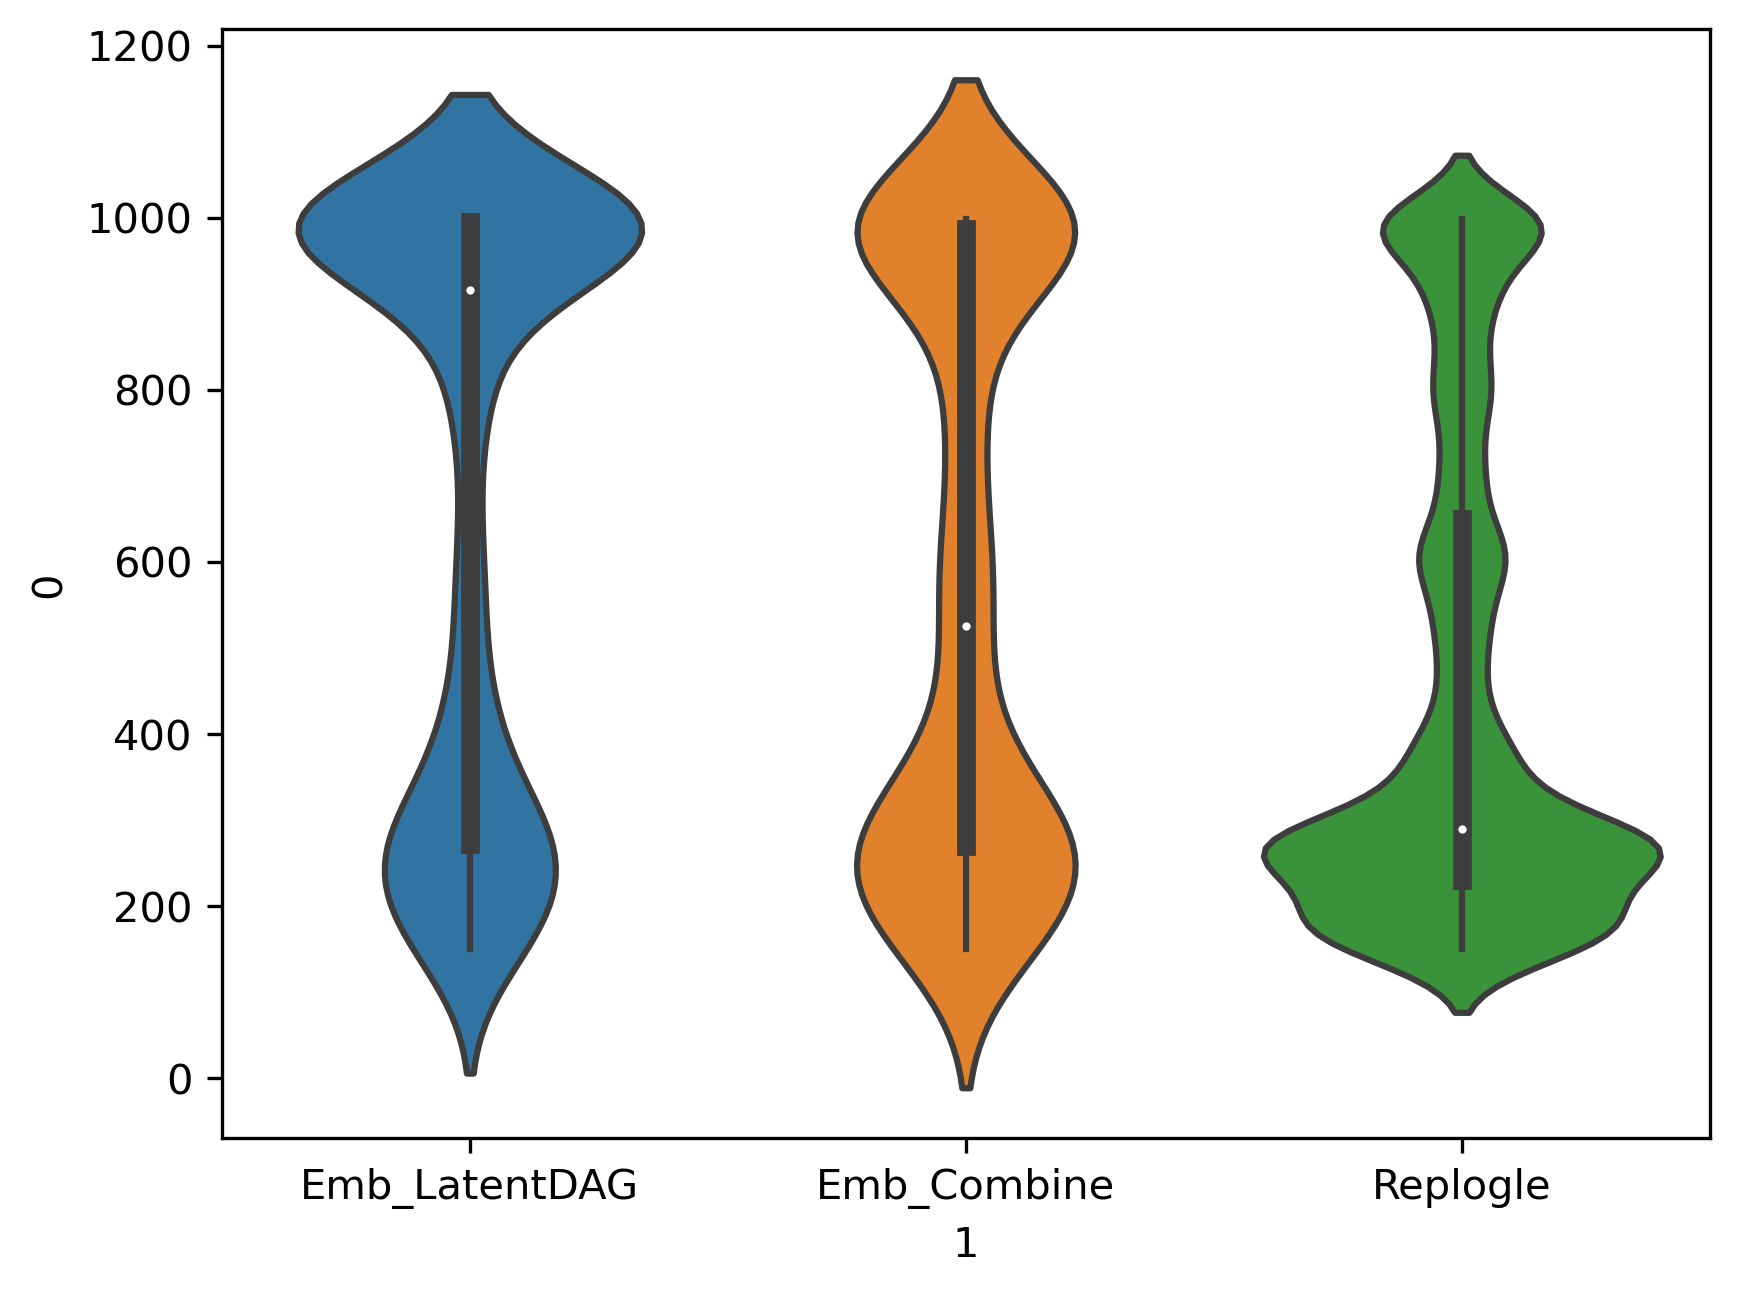

In [9]:
plt.figure(dpi=300)
sns.violinplot(data=result, y=0, x=1)
plt.savefig("pairs_string.pdf", dpi='figure', bbox_inches='tight')

In [10]:
from scipy.stats import ttest_ind
ttest_ind(v1, v2, equal_var=False)

Ttest_indResult(statistic=33.32480599875029, pvalue=1.9232612547999883e-205)

In [11]:
from scipy.stats import ttest_ind
ttest_ind(v1, v3, equal_var=False)

Ttest_indResult(statistic=8.821326370143687, pvalue=1.959957947815505e-18)

### compare co-exp

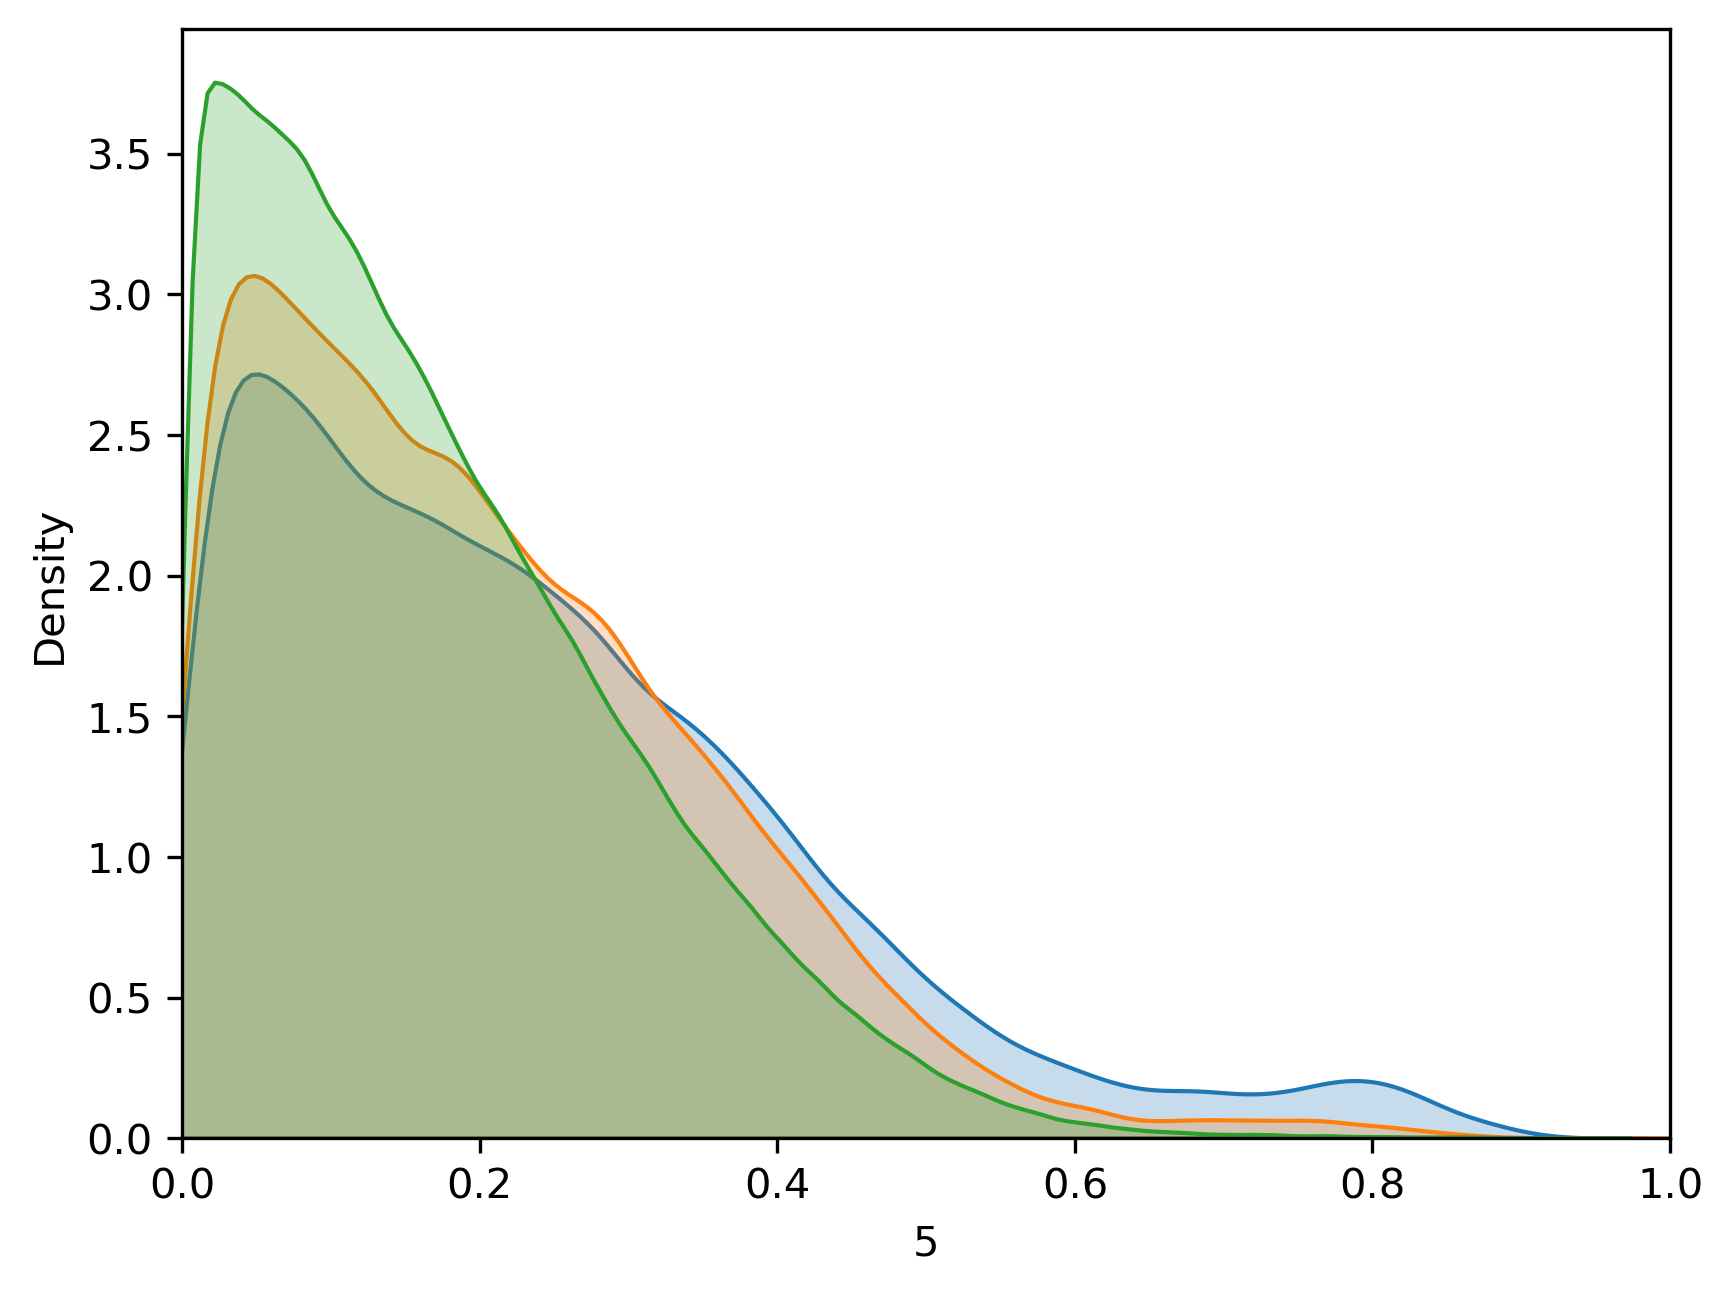

In [12]:
plt.figure(dpi=300)
sns.kdeplot(all_pairs[all_pairs[1]][5].abs(), fill=True, alpha=0.25)
sns.kdeplot(all_pairs[all_pairs[3]][5].abs(), fill=True, alpha=0.25)
sns.kdeplot(all_pairs[all_pairs[2]][5].abs(), fill=True, alpha=0.25)
plt.xlim([0,1])
plt.savefig("pairs_coexp.pdf", dpi='figure', bbox_inches='tight')